# Regression Script
## Partial Least Squares

### Florian Beyer
### 2020-04-28
### V0.2

Quelle:
- https://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.PLSRegression.html
- https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
- https://heartbeat.fritz.ai/random-forest-regression-in-python-using-scikit-learn-9e9b147e2153
- variable importance: https://github.com/scikit-learn/scikit-learn/issues/7050

In [68]:
# Requried Packages
from osgeo import gdal, ogr, gdal_array # I/O image data
import numpy as np # math and array handling
import matplotlib.pyplot as plt # plot figures
import pandas as pd # handling large data as table sheets
from joblib import dump, load
from operator import itemgetter

from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

In [2]:
# data input

# define a number of trees that should be used (default = 500)
est = 1000

# Size of splitting the data (0.1 -> 10 % test data, 90 % training data)
testSize = 0.25

# the remote sensing image you want to classify
img_RS = 'D:\\OwnCloud\\WetScapes\\2020_02_21_Regression_Biomass\\Daten\\stack_all_data_tif.tif'

# training and validation
#    as image in the same extand as your remote sensing image
#    no data pixels = 0 or negative
#    class pixels > 0 and as integer
field = 'D:\\OwnCloud\\WetScapes\\2020_02_21_Regression_Biomass\\Daten\\biomasse_all.shp'


# what is the attributes name of your classes in the shape file (field name of the classes)?
attribute = 'FM_in_Gram'


# save path, predicted image
prediction_map = 'D:\\OwnCloud\\WetScapes\\2020_02_21_Regression_Biomass\\Results\\PLSR_prediction_map.tif'


# save path, trained model
save_model = 'D:\\OwnCloud\\WetScapes\\2020_02_21_Regression_Biomass\\Results\\PLSR_model.joblib'


In [6]:
# laod training data and show all shape attributes

#model_dataset = gdal.Open(model_raster_fname)
shape_dataset = ogr.Open(field)
shape_layer = shape_dataset.GetLayer()

# extract the names of all attributes (fieldnames) in the shape file
attributes = []
ldefn = shape_layer.GetLayerDefn()
for n in range(ldefn.GetFieldCount()):
    fdefn = ldefn.GetFieldDefn(n)
    attributes.append(fdefn.name)
    
# print the attributes
print('Available attributes in the shape file are: {}'.format(attributes))

Available attributes in the shape file are: ['P', 'Ost', 'West', 'Hoch', 'FM', 'Proben_ID', 'TM_in_%FM', 'oTM_in_%FM', 'Asche_in_%', 'FM_in_Gram', 'TM_in_Gram']


In [7]:
# Data preparation

# load image data

img_ds = gdal.Open(img_RS, gdal.GA_ReadOnly)

img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()

In [8]:
# Data preparation
# load training data from shape file

#model_dataset = gdal.Open(model_raster_fname)
shape_dataset = ogr.Open(field)
shape_layer = shape_dataset.GetLayer()
mem_drv = gdal.GetDriverByName('MEM')
mem_raster = mem_drv.Create('',img_ds.RasterXSize,img_ds.RasterYSize,1,gdal.GDT_UInt16)
mem_raster.SetProjection(img_ds.GetProjection())
mem_raster.SetGeoTransform(img_ds.GetGeoTransform())
mem_band = mem_raster.GetRasterBand(1)
mem_band.Fill(0)
mem_band.SetNoDataValue(0)

att_ = 'ATTRIBUTE='+attribute
# http://gdal.org/gdal__alg_8h.html#adfe5e5d287d6c184aab03acbfa567cb1
# http://gis.stackexchange.com/questions/31568/gdal-rasterizelayer-doesnt-burn-all-polygons-to-raster
err = gdal.RasterizeLayer(mem_raster, [1], shape_layer, None, None, [1],  [att_,"ALL_TOUCHED=TRUE"])
assert err == gdal.CE_None

roi = mem_raster.ReadAsArray()


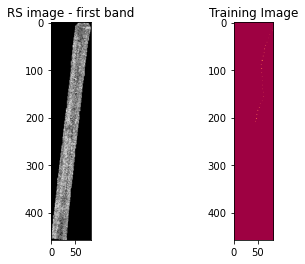

In [9]:
# Display image and Training data

plt.subplot(121)
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
plt.title('RS image - first band')

plt.subplot(122)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('Training Image')

plt.show()


In [10]:
# Number of training pixels:
n_samples = (roi > 0).sum()
print('We have {n} training samples'.format(n=n_samples))# Subset the image dataset with the training image = X

We have 25 training samples


In [11]:
# Mask the classes on the training dataset = y
# These will have n_samples rows
X = img[roi > 0, :]
y = roi[roi > 0]

In [12]:
features = pd.DataFrame(X)

band_names = []
for i in range(X.shape[1]):
#for i in range(0,2500):
    nband = "Band_"+ str(i+1)
    band_names.append(nband)

features.columns = band_names

print('The shape of our features is:', features.shape)
print('The number of Spectra is:', features.shape[0])
print('The number of bands is:', features.shape[1])

features['value'] = y

features.head()

The shape of our features is: (25, 19)
The number of Spectra is: 25
The number of bands is: 19


,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,Band_8,Band_9,Band_10,Band_11,Band_12,Band_13,Band_14,Band_15,Band_16,Band_17,Band_18,Band_19,value
0,129.0,113.0,80.0,4.806193,0.057959,0.071329,0.145246,0.186718,0.447160,181.0,170.0,130.0,4.678855,0.088964,0.101915,0.221553,0.261760,0.439525,0.127338,160
1,119.0,114.0,69.0,4.965296,0.054273,0.052538,0.145605,0.197211,0.579276,157.0,144.0,106.0,4.684095,0.106843,0.114630,0.236461,0.277434,0.415248,0.281201,150
2,136.0,118.0,83.0,4.754364,0.067470,0.079177,0.150295,0.184098,0.398524,199.0,199.0,161.0,4.567229,0.108079,0.130173,0.212995,0.240255,0.297173,0.189366,70
3,137.0,124.0,81.0,4.482555,0.060446,0.067874,0.163100,0.215910,0.521650,150.0,134.0,110.0,4.244701,0.080401,0.099191,0.165962,0.195841,0.327592,0.230469,180
4,141.0,139.0,88.0,3.828756,0.072505,0.065997,0.212558,0.272465,0.610018,183.0,173.0,139.0,3.538703,0.089225,0.101101,0.212972,0.253492,0.429764,0.290053,270


In [13]:
# Labels are the values we want to predict
labels = np.array(features['value'])

# Remove the labels from the features
# axis 1 refers to the columns
features = features.drop('value', axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = testSize, random_state = randomState)

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (18, 19)
Training Labels Shape: (18,)
Testing Features Shape: (7, 19)
Testing Labels Shape: (7,)


In [46]:
plsr = PLSRegression(n_components=4,
                     scale=True,
                     max_iter=500,
                     tol=1e-06,
                     copy=True)

plsr.fit(train_features, train_labels)

PLSRegression(copy=True, max_iter=500, n_components=4, scale=True, tol=1e-06)

In [47]:
print(plsr.score(train_features, train_labels))

0.8287335159095089


In [59]:
# band importances

# function for variable importance
def vip(model):
    t = model.x_scores_
    w = model.x_weights_
    q = model.y_loadings_
    p, h = w.shape
    vips = np.zeros((p,))
    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)
    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(s.T @ weight)/total_s)
    return vips

importance = vip(plsr)

imp = {}
for i in range(features.shape[1]):
    print('Band {}: {}'.format(i+1, importance[i]))
    imp['Band{}'.format(i+1)] = importance[i]

Band 1: 0.8654274217819309
Band 2: 0.7920490900351752
Band 3: 1.2088755654451426
Band 4: 1.0700223428766995
Band 5: 0.4941257157366325
Band 6: 0.7511952962249925
Band 7: 0.8755354005284008
Band 8: 0.8665203521419863
Band 9: 0.9999171433322372
Band 10: 0.6914371632411921
Band 11: 0.9176207996106249
Band 12: 1.4639246831827593
Band 13: 1.1254387436424453
Band 14: 1.1025099392171334
Band 15: 0.9893361920564802
Band 16: 1.1944693866906873
Band 17: 1.2098697321710072
Band 18: 1.1089368226883307
Band 19: 0.8045240004082783


In [69]:
sorted_imp = dict(sorted(imp.items(), key=itemgetter(1), reverse=True))
sorted_imp 

{'Band12': 1.4639246831827593,
 'Band17': 1.2098697321710072,
 'Band3': 1.2088755654451426,
 'Band16': 1.1944693866906873,
 'Band13': 1.1254387436424453,
 'Band18': 1.1089368226883307,
 'Band14': 1.1025099392171334,
 'Band4': 1.0700223428766995,
 'Band9': 0.9999171433322372,
 'Band15': 0.9893361920564802,
 'Band11': 0.9176207996106249,
 'Band7': 0.8755354005284008,
 'Band8': 0.8665203521419863,
 'Band1': 0.8654274217819309,
 'Band19': 0.8045240004082783,
 'Band2': 0.7920490900351752,
 'Band6': 0.7511952962249925,
 'Band10': 0.6914371632411921,
 'Band5': 0.4941257157366325}

In [70]:
# predict test data
predictions_test_ds = plsr.predict(test_features)


In [88]:
# Calculate the absolute errors
errors = abs(predictions_test_ds - test_labels)
# Print out the mean absolute error (mae)

# Print out the mean absolute error (mae)


print('-------------')
print('n of the test data: {}'.format(len(test_labels)))
print('Mean of the variable: {:.2f}'.format(np.mean(labels)))
print('Standard deviation of the variable: {:.2f}'.format(np.std(labels)))
print('-------------')
print('Mean Absolute Error: {:.2f}'.format(np.mean(errors)))

mse = mean_squared_error(test_labels, predictions_test_ds)
print('Mean squared error: {:.2f}'.format(mse))
print('RMSE: {:.2f}'.format(np.sqrt(mse)))

'''
To put our predictions in perspective, we can calculate an accuracy using
the mean average percentage error subtracted from 100 %.
'''

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('mean absolute percentage error (MAPE) / Accuracy: {:.2f}'.format(accuracy), '%.')
print('-------------')
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination r²: {:.2f}'.format(r2_score(test_labels, predictions_test_ds)))



-------------
n of the test data: 7
Mean of the variable: 273.20
Standard deviation of the variable: 164.63
-------------
Mean Absolute Error: 142.10
Mean squared error: 45579.25
RMSE: 213.49
mean absolute percentage error (MAPE) / Accuracy: 35.19 %.
-------------
Coefficient of determination r²: -1.38


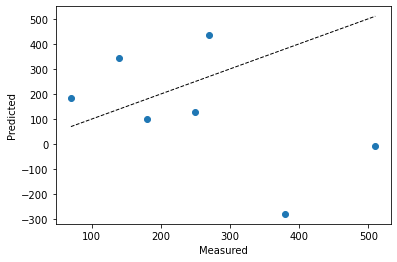

In [25]:
fig, ax = plt.subplots()
ax.scatter(test_labels, predictions_test_ds)
ax.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')

plt.show()

In [74]:
# Predicting the rest of the image

# Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (img.shape[0] * img.shape[1], img.shape[2])
img_as_array = img[:, :, :].reshape(new_shape)

print('Reshaped from {o} to {n}'.format(o=img.shape, n=img_as_array.shape))

img_as_array = np.nan_to_num(img_as_array)

Reshaped from (458, 83, 19) to (38014, 19)


In [75]:
prediction_ = plsr.predict(img_as_array)

In [76]:
prediction = prediction_.reshape(img[:, :, 0].shape)
print('Reshaped back to {}'.format(prediction.shape))

Reshaped back to (458, 83)


In [77]:
# Save regression

cols = img.shape[1]
rows = img.shape[0]

prediction.astype(np.float16)

driver = gdal.GetDriverByName("gtiff")
outdata = driver.Create(prediction_map, cols, rows, 1, gdal.GDT_UInt16)
outdata.SetGeoTransform(img_ds.GetGeoTransform())##sets same geotransform as input
outdata.SetProjection(img_ds.GetProjection())##sets same projection as input
outdata.GetRasterBand(1).WriteArray(prediction)
outdata.FlushCache() ##saves to disk!!
print('Image saved to: {}'.format(prediction_map))

Image saved to: D:\OwnCloud\WetScapes\2020_02_21_Regression_Biomass\Results\PLSR_prediction_map.tif


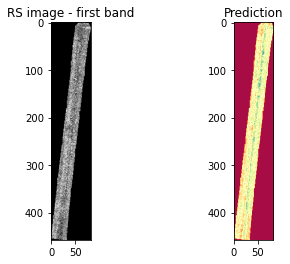

In [89]:
# Display images
plt.subplot(121)
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
plt.title('RS image - first band')

plt.subplot(122)
plt.imshow(prediction, cmap=plt.cm.Spectral)
plt.title('Prediction')

plt.show()